# 데이터 전처리 성능 비교

## data1

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from xgboost import XGBRegressor


def data1_prepro(df1=None, train=False, onehot=True):
    '''
    data1 전처리 함수.

    args:
        train : 학습용으로 전처리할것인지
        onehot : 원핫인코딩 할것인지 타겟인코딩 할것인지 (False=타겟인코딩)
    
    returns:
        X_train, X_test, y_train, y_test : train=True인경우
        X : train=False인 경우
    '''
    if not df1:
        df1 = pd.read_csv('data/Regression_data.csv')

    num_cols = df1.drop(columns=['Sex', 'Rings']).columns
    cat_cols = ['Sex']

    # Height 이상치 클립 : 최대값 0.3
    df1.Height.clip(upper=0.3, inplace=True)

    # ohe 인경우 먼저 인코딩
    scaler = StandardScaler()
    scaler.set_output(transform='pandas')
    ohe = OneHotEncoder(sparse_output=False)
    ohe.set_output(transform='pandas')
    te = TargetEncoder(target_type='continuous')
    te.set_output(transform='pandas')

    # 컬럼 변환기1 : Sex ohe, 나머지 표준화
    data1_ct_ohe = make_column_transformer(
        (ohe, cat_cols),
        (scaler, num_cols),
        remainder='passthrough'
    )
    data1_ct_ohe.set_output(transform='pandas')

    # 컬럼 변환기2 : Sex te, 나머지 표준화
    data1_ct_te = make_column_transformer(
        (te, cat_cols),
        (scaler, num_cols),
        remainder='passthrough'
    )
    data1_ct_te.set_output(transform='pandas')

    if 'Rings' in df1:
        X = df1.drop(columns='Rings')   
        y = df1.Rings
    else:
        X = df1

    if train:
        # test비율 20%로
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.2,
                                                            random_state=42)
        if onehot:
            X_train = data1_ct_ohe.fit_transform(X_train)
            X_test = data1_ct_ohe.transform(X_test)
        else:
            X_train = data1_ct_te.fit_transform(X_train, y_train)
            X_test = data1_ct_te.transform(X_test)
        return X_train, X_test, y_train, y_test
    else:
        return X
    

X_train, X_test, y_train, y_test = data1_prepro(train=True)
X_train_te, X_test_te, y_train_te, y_test_te = data1_prepro(train=True, onehot=False)

model = XGBRegressor(n_estimators=500,
                     objective='reg:squarederror',
                     booster='gbtree',
                     max_depth=8,
                     learning_rate=0.01,
                     tree_method='gpu_hist',
                     gpu_id=0,
                     eval_metric='rmse',
                     early_stopping_rounds=20,
                     random_state=42)

model2 = XGBRegressor(n_estimators=500,
                     objective='reg:squarederror',
                     booster='gbtree',
                     max_depth=8,
                     learning_rate=0.01,
                     tree_method='gpu_hist',
                     gpu_id=0,
                     eval_metric='rmse',
                     early_stopping_rounds=20,
                     random_state=42)

model.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          verbose=False)

model2.fit(X_train_te, y_train_te,
          eval_set=[(X_test_te, y_test_te)],
          verbose=False)
''

''

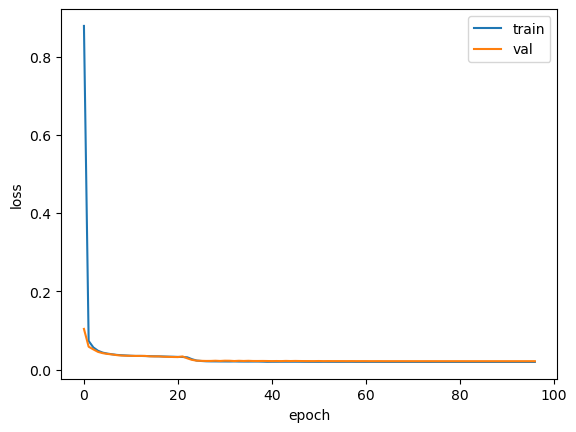

In [20]:
# AE로 차원축소
import tensorflow.keras as keras
import tensorflow as tf
import time


def AE_feature_extraction(X):
    """
    오토인코더로 차원축소 7 => 4
    학습후에 인코더만 반환
    """
    # 7 => 4
    encoder = keras.models.Sequential([
        keras.layers.Dense(4, activation='relu')
        ]
    )
    # 4 => 7
    decoder = keras.models.Sequential([
        keras.layers.Dense(7, activation=None)
        ]
    )
    # 컴파일 : loss = mse, opt = adam
    AutoEncoder = keras.Sequential([encoder, decoder])
    AutoEncoder.compile(optimizer=keras.optimizers.Adam(0.01),
                        loss='mse')
    
    # 콜백 정의
    # reduce_lr : 학습이 잘 안되면(6 epochs) 학습률 감소
    # e_stop : 특정epoch이상 차도 없으면(12 epochs) 중단
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.5, patience=6,
                                                     verbose=0, mode='auto')
    e_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=12,
                                              restore_best_weights=True)
    # 학습
    hist = AutoEncoder.fit(X, X,
                           batch_size=32,
                           validation_split=.25,
                           epochs=200,
                           callbacks=[e_stop, reduce_lr],
                           verbose=0)
    
    # 오토인코더 train, val의 epoch별 loss확인
    plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='val')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    return encoder

encoder = AE_feature_extraction(X_train.iloc[:,3:])

In [21]:
X_train2 = np.hstack((X_train.iloc[:,:3], encoder.predict(X_train.iloc[:,3:], verbose=0)))
X_test2 = np.hstack((X_test.iloc[:,:3], encoder.predict(X_test.iloc[:,3:], verbose=0)))

model3 = XGBRegressor(n_estimators=500,
                     objective='reg:squarederror',
                     booster='gbtree',
                     max_depth=8,
                     learning_rate=0.01,
                     tree_method='gpu_hist',
                     gpu_id=0,
                     eval_metric='rmse',
                     early_stopping_rounds=20,
                     random_state=42)

model3.fit(X_train2, y_train,
           eval_set=[(X_test2, y_test)],
           verbose=False)
''

''

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)

X_train3 = pca.fit_transform(X_train.iloc[:,3:])
X_test3 = pca.transform(X_test.iloc[:,3:])

X_train3 = np.hstack((X_train.iloc[:,:3], X_train3))
X_test3 = np.hstack((X_test.iloc[:,:3], X_test3))

model4 = XGBRegressor(n_estimators=500,
                     objective='reg:squarederror',
                     booster='gbtree',
                     max_depth=8,
                     learning_rate=0.01,
                     tree_method='gpu_hist',
                     gpu_id=0,
                     eval_metric='rmse',
                     early_stopping_rounds=20,
                     random_state=42)

model4.fit(X_train3, y_train,
           eval_set=[(X_test3, y_test)],
           verbose=False)
''

''

In [131]:
# 혹시 모르니 skewness 조정된 버전도 실험
from scipy.stats import boxcox
from scipy.special import boxcox1p

def data1_prepro_noskew(df1=None):

    if not df1:
        df1 = pd.read_csv('data/Regression_data.csv')

    num_cols = df1.drop(columns=['Sex', 'Rings']).columns
    cat_cols = ['Sex']

    # Height 이상치 클립 : 최대값 0.3
    df1.Height.clip(upper=0.3, inplace=True)

    # boxcox로 Sex, Ring제외 skewness 전부 조정
    temp = df1[num_cols].apply(lambda x: x+0.001).apply(lambda x: boxcox(x)[0])
    X = pd.concat([df1[cat_cols], temp], axis=1)
    y = df1.Rings

    # ohe 인경우 먼저 인코딩
    scaler = StandardScaler()
    scaler.set_output(transform='pandas')
    ohe = OneHotEncoder(sparse_output=False)
    ohe.set_output(transform='pandas')

    # 컬럼 변환기1 : Sex ohe, 나머지 표준화
    data1_ct_ohe = make_column_transformer(
        (ohe, cat_cols),
        (scaler, num_cols),
        remainder='passthrough'
    )
    data1_ct_ohe.set_output(transform='pandas')
    
    # test비율 20%로
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        random_state=40)
    
    X_train = data1_ct_ohe.fit_transform(X_train)
    X_test = data1_ct_ohe.transform(X_test)

    return X_train, X_test, y_train, y_test

X_train4, X_test4, y_train4, y_test4 = data1_prepro_noskew()

model5 = XGBRegressor(n_estimators=500,
                     objective='reg:squarederror',
                     booster='gbtree',
                     max_depth=8,
                     learning_rate=0.01,
                     tree_method='gpu_hist',
                     gpu_id=0,
                     eval_metric='rmse',
                     early_stopping_rounds=20,
                     random_state=42)

model5.fit(X_train4, y_train4,
           eval_set=[(X_test4, y_test4)],
           verbose=False)
''

''

In [143]:
def cv(model, X_train, X_test, y_train, y_test):
    rmse =cross_val_score(model, X_train, y_train,
                          scoring='neg_mean_squared_error',
                          cv=5,
                          fit_params={'eval_set':[(X_test, y_test)],
                                      'verbose':False,})

    rmse = np.sqrt(np.abs(rmse))
    return rmse

ohe_rmse = cv(model, X_train, X_test, y_train, y_test)
ohe_noskew_rmse = cv(model5, X_train4, X_test4, y_train4, y_test4)
te_rmse = cv(model2, X_train_te, X_test_te, y_train_te, y_test_te)
ae_rmse = cv(model3, X_train2, X_test2, y_train, y_test)
pca_rmse = cv(model4, X_train3, X_test3, y_train, y_test)

print(f'ohe cv rmse : {ohe_rmse}')
print(f'ohe cv noskew rmse : {ohe_noskew_rmse}')
print(f'te cv rmse : {te_rmse}')
print(f'ae cv rmse : {ae_rmse}')
print(f'pca cv rmse : {pca_rmse}\n')

print(f'ohe mean rmse : {np.mean(ohe_rmse)}')
print(f'ohe noskew mean rmse : {np.mean(ohe_noskew_rmse)}')
print(f'te mean rmse : {np.mean(te_rmse)}')
print(f'ae mean rmse : {np.mean(ae_rmse)}')
print(f'pca mean rmse : {np.mean(pca_rmse)}')

# xgboost가 공선성에 강하므로 AE, PCA를 통한 feature extraction은 큰 의미는 없는것 같다.
# 마찬가지로 skewness를 없애고 진행해도 결과차이는 크지 않다.


ohe cv rmse : [2.0640369  2.29157908 2.29728733 2.17979154 2.00275552]
ohe cv noskew rmse : [2.19021825 2.2022373  2.21177252 2.15222797 2.219526  ]
te cv rmse : [2.07481908 2.31469053 2.29444519 2.16152719 2.05606906]
ae cv rmse : [2.16315881 2.44069981 2.43922467 2.28064144 2.11798293]
pca cv rmse : [2.13613558 2.42536024 2.32408536 2.27655981 2.10901572]

ohe mean rmse : 2.167090074629537
ohe noskew mean rmse : 2.1951964094506162
te mean rmse : 2.1803102090912247
ae mean rmse : 2.288341532186832
pca mean rmse : 2.2542313412077624


## data1 전처리 요약
* Height 이상치 처리
* Sex 원핫인코딩, 혹은 타겟인코딩
* 수치형 변수 skewness조정시도
* 수치형 변수들 표준화
* 두가지 차원축소 방법 채택 (AE, PCA)
---
결과
* ohe, te, ae, pca 쓴 결과들이 전부 비슷하다.  
* skewness조정한것과 안한것의 차이거의없다.

    => 전처리에서 더 할게 있나??

## data2

## data3